In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
path = "D202.csv"
df = pd.read_csv(path)
#df = df.sample(frac=0.03)
#df.reset_index(drop=True, inplace=True)
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [ ]:
print(df.isnull().sum())

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64


In [ ]:
#df = df.sample(frac=0.002)
#df = df.drop([0])
#df = df.drop(columns=['NOTES'])
dates = df['DATE'].values
temp = df['USAGE'].values


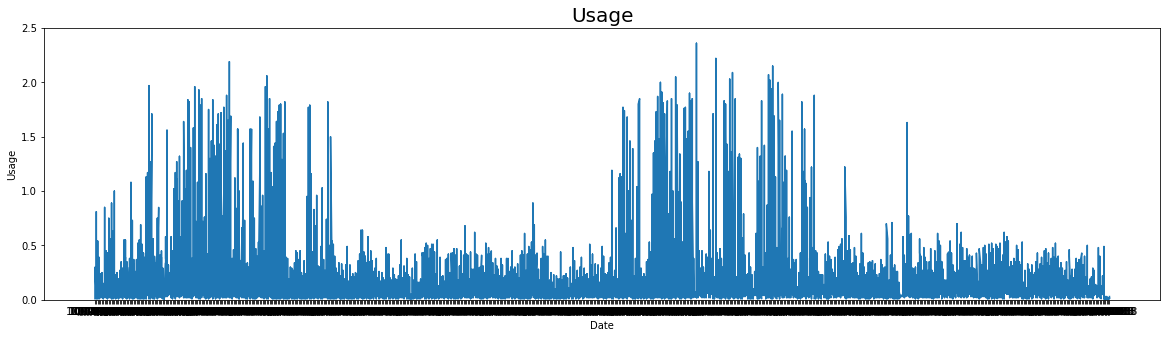

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dates, temp)
plt.ylim([0,2.5])
plt.ylabel('Usage')
plt.xlabel('Date')
plt.title('Usage', fontsize=20);

Bagi dataset

In [ ]:
from sklearn.model_selection import train_test_split
x_latih, x_test, y_latih, y_test = train_test_split(temp, dates, test_size = 0.2)

Total pembagian data

In [ ]:
print("Training data: ", len(x_latih))
print("Val data: ", len(x_test))

Training data:  56294
Val data:  14074


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

Buat Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

Menghitung MAE (Mean Absolute Error)

In [ ]:
Mae = (df['USAGE'].max() - df['USAGE'].min()) * 10/100
print(Mae)

0.236


Penggunaan Callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.0 and logs.get('val_mae')<2.0):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=15, 
                    validation_data = val_set,
                    batch_size=1024,
                    #callbacks=[callbacks]
                    )

Epoch 1/15
563/563 [==============================] - 47s 79ms/step - loss: 0.0207 - mae: 0.1080 - val_loss: 0.0207 - val_mae: 0.1120
Epoch 2/15
563/563 [==============================] - 45s 79ms/step - loss: 0.0207 - mae: 0.1118 - val_loss: 0.0207 - val_mae: 0.1133
Epoch 3/15
563/563 [==============================] - 45s 80ms/step - loss: 0.0207 - mae: 0.1124 - val_loss: 0.0207 - val_mae: 0.1135
Epoch 4/15
563/563 [==============================] - 46s 82ms/step - loss: 0.0207 - mae: 0.1125 - val_loss: 0.0207 - val_mae: 0.1135
Epoch 5/15
563/563 [==============================] - 44s 78ms/step - loss: 0.0207 - mae: 0.1125 - val_loss: 0.0207 - val_mae: 0.1135
Epoch 6/15
563/563 [==============================] - 44s 78ms/step - loss: 0.0207 - mae: 0.1125 - val_loss: 0.0207 - val_mae: 0.1136
Epoch 7/15
563/563 [==============================] - 44s 78ms/step - loss: 0.0207 - mae: 0.1125 - val_loss: 0.0207 - val_mae: 0.1135
Epoch 8/15
563/563 [==============================] - 44s 78ms

Plot Akurasi dan Loss

Plot Akurasi

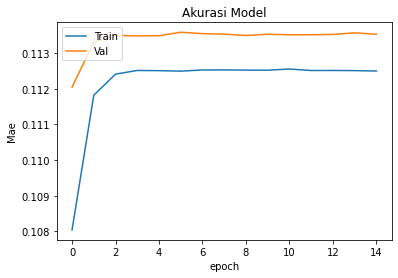

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Plot Loss

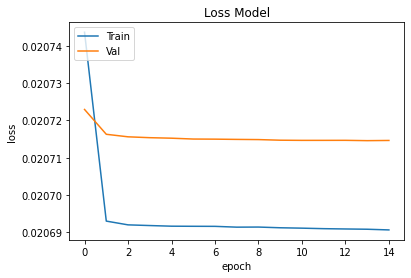

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()